<a id='intro'></a>
# Matching messy Pandas columns with FuzzyWuzzy :

![header](https://i.ibb.co/wLxk8nK/dinoheader-th.jpg)

In this article, I'm going to show you how to use the Python package **FuzzyWuzzy** to **match two Pandas dataframe columns** based on **string similarity**; the intended outcome is to have each value of column A matched with the closest corresponding value in column B, which is then put in the same row.

To do so, I'm going to use a messy real world case I personally encountered (personal and corporate info are substituted with fictitious and randomly generated data).

Now before tackling our little problem, here's what to expect from this article :
* Often times, when you work with different data sources, the same entity (business, country, address, phone number, hotel room type, music album, sport team, ...) could be written or worded differently. In this article, we're going to work on matching full names with emails. However, you can apply the same techniques for any string matching problem you encounter (string is just text, simply put) ; <br><br>

* You can follow along with me by downloading the **Jupyter Notebook** and **the data** from my [Github repository](https://github.com/kelmouloudi/MediumArticle-FuzzyWuzzy). Alternatively, you can [browse the Jupyter Notebook online](https://mybinder.org/v2/gh/kelmouloudi/MediumArticle-FuzzyWuzzy/master) without having to download anything (it could take a little while to load though) ;<br><br>

* This is a very beginner friendly article. I made sure to include an **appendix** towards the end where I explain in as much details as possible every code snippet that may seem complicated (just click the `code explanation` link on the top-right corner of code cells to get to the explanation in the appendix, then hit `go back` to go back to the original cell). 
However, a basic understanding of Python, Jupyter Notebooks and Pandas (which is a Python package used for data handling and analysis, among other things) will help you greatly.

<a id='table'></a>

---
# Table of contents :

* [Introduction](#intro) <br>
* [The problem](#theproblem)<br>
* [The packages](#thepackages)<br>
* [The data](#thedata)<br>
* [The "dumb but it kinda works" solution](#thedumb)<br>
* [The boring FuzzyWuzzy lecture](#theboring)<br>
* [The not so boring FuzzyWuzzy application](#thenotsoboring)<br>
* [The audit](#theaudit)<br>
* [The quest for the best FuzzyWuzzy scorer](#thequest)<br>
* [The battle of the scorers](#thebattle)<br>
* [The verdict](#theverdict)<br>
* [The appendix (code explanations)](#theappendix)
* [Parting notes](#parting)

<a id='theproblem'></a>

---
[Go back to table of contents ^](#table)
# The problem :

![baby](https://i.ibb.co/jvKJF9C/giant-baby.jpg)

I work at a company called Giant Baby Bibs&trade; that specializes in making bibs for giant babies. GBB has 200 employees. One day I needed to make a list of all employees and their emails. Big surprise: the HR department has a file of all employee IDs and full names but not emails, and the IT department has a CSV file containing all of the emails but no employee IDs or names whatsoever.

As if that isn't messy enough, the IT department doesn't have a clear established rule to how an email should be derived from the full name of an employee. For example, for an employee called **John Doe**, the email could be j.doe@giantbabybibs.org, or jdoe@giantbabybibs.org or even johndoe@giantbabybibs.org (especially for employees who have very short last names).

Now the real kicker comes with employees who have a middle name. For **John Sebastian Doe** for instance, emails could be jsdoe@giantbabybibs.org or j.sebastian.doe@giantbabybibs.org or j.sebastian@giantbabybibs.org or any variation the webmaster felt was appropriate at the time. Way to go Kevin!

<a id='thepackages'></a>

---
[Go back to table of contents ^](#table)
# The packages :

First things first, let's import `Pandas` :

In [1]:
import pandas as pd

If you don't have `FuzzyWuzzy` installed, you can install it by running `pip install fuzzywuzzy[speedup]` inside your Jupyter notebook or from the PIP or Anaconda prompt. If this doesn't work, you should install `FuzzyWuzzy` like this: `pip install fuzzywuzzy` and then install `python-levenshtein` like this: `pip install python-Levenshtein` (in order to speed the matching process).

From `FuzzyWuzzy`, we'll mainly need two modules: `process` and `fuzz` :

In [2]:
from fuzzywuzzy import process, fuzz

Let's also import `matplotlib` for some data visualizations down the road :

In [3]:
import matplotlib.pyplot as plt

 And for good measure, let's add some CSS to style our dataframes for added contrast between the axes and the data itself (If you don't like this style, just delete the cell, restart the kernel and re-run all cells). <br>
<sub id='codex'>[code explanation 1](#codex1)</sub>
<a id='code1'></a>

In [4]:
%%HTML
<style>.dataframe th, td:first-child{background:#3f577c;font-family:monospace;color:white;border:3px solid white;
text-align:left !important;}#codex{float:right;}</style>

This next bit just insures the custom CSS style we just applied stays on when we use `style.background_gradient` later on:

In [5]:
th_props = [('background','#3f577c'), ('font-family','monospace'), ('color','white'),('border','3px solid white'),
            ('text-align','left !important')]
styles = [dict(selector="th", props=th_props)]

<a id='thedata'></a>

---
[Go back to table of contents ^](#table)
# The data :

We have two dataframes or tables we'll need to match here :
* `hr` that contains employee IDs and full names, as maintained by the HR department ;
* `it` that contains only the emails extracted by the IT department.

Make sure to change the 'data/hr.csv' and 'data/it.csv' paths to where your data is placed in your machine (don't forget to get the data from this article's [Github repository](https://github.com/kelmouloudi/MediumArticle-FuzzyWuzzy) :

In [6]:
hr = pd.read_csv('data/hr.csv', encoding='unicode_escape')
it = pd.read_csv('data/it.csv', encoding='unicode_escape')

display( hr.head(3) )
display( it.head(3) )

,employee_id,full_name
0,3CA946A9,Kortney Lapierre Brazee
1,FFB74DA3,Gita Meidinger
2,68B6478E,Georgia Ro Basil


,email
0,l.kane@giantbabybibs.org
1,catkison@giantbabybibs.org
2,t.raney@giantbabybibs.org


Here, we have 200 employees in the `hr` dataframe and 200 emails in the `it` dataframe. To each employee corresponds a single email, and vice versa.

<a id='thedumb'></a>

---
[Go back to table of contents ^](#table)
# The "dumb but it kinda works" solution :

Before working the magic of `FuzzyWuzzy`, I'd like to explore a solution to this problem that I initially went with at the beginning. The idea is to :

1. Automatically generate an email (let's call it `gen_email`) using the first letter of the first name coupled with the last name, and separated with a dot. So, for John Doe, the generated email will be j.doe@giantbabybibs.org. By exploring the list of actual emails, this seems like the dominating trend ;
2. Compare the `gen_email` column with the actual `email` column and output a value of **True** if the generated email exists in the actual email list, and a value of **False** if it doesn't. The True and False values will be stored in a column called `exists`.

Now, let's make the `gen_email` column within the `hr` dataframe : <br>
<sub id='codex'>[code explanation 2](#codex2)</sub>
<a id='code2'></a>

In [7]:
hr['gen_email'] = hr['full_name'].str[0] + '.' + hr['full_name'].str.split().str[1] + '@giantbabybibs.org'
hr['gen_email'] = hr['gen_email'].str.lower()
hr.head(3)

,employee_id,full_name,gen_email
0,3CA946A9,Kortney Lapierre Brazee,k.lapierre@giantbabybibs.org
1,FFB74DA3,Gita Meidinger,g.meidinger@giantbabybibs.org
2,68B6478E,Georgia Ro Basil,g.ro@giantbabybibs.org


Now let's check if the `gen_email` values exist in the actual `email` list. For this, we'll create an additional column called `exists` that accepts **True** if the generated email is correct, and **False** otherwise : <br>
<sub id='codex'>[code explanation 3](#codex3)</sub>
<a id='code3'></a>

In [8]:
hr['exists'] = hr.apply(lambda x: x.gen_email in list(it.email), axis=1)
hr.head(3)

,employee_id,full_name,gen_email,exists
0,3CA946A9,Kortney Lapierre Brazee,k.lapierre@giantbabybibs.org,False
1,FFB74DA3,Gita Meidinger,g.meidinger@giantbabybibs.org,True
2,68B6478E,Georgia Ro Basil,g.ro@giantbabybibs.org,False


How many emails did we get right using this method? <br>
<sub id='codex'>[code explanation 4](#codex4)</sub>
<a id='code4'></a>

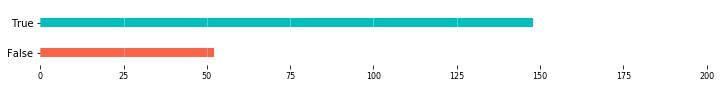

In [9]:
ax = hr.exists.value_counts().sort_values().plot(kind='barh', color=['tomato', 'c'], figsize=(12,1), width=0.3)
plt.xlim(0,201), plt.xticks(fontsize=8), ax.set_frame_on(False), plt.grid(color='white', alpha=.4, axis='x') ;

So, out of 200, it turns out we got **148 emails right** and **52 emails wrong** (a success rate of 74%). Not bad! We could dig deeper with `if` statements covering the other ways an email could have been generated (without the dot, using the middle name instead of the last name, etc.), but let's use FuzzyWuzzy for now.

<a id='theboring'></a>

---
[Go back to table of contents ^](#table)
# The boring FuzzyWuzzy lecture :

Let's start with a basic intro to `FuzzyWuzzy`. This nifty package compares two strings A and B and outputs a ratio that estimates the distance between them. We are talking here about the **Levenshtein distance**, which is the distance between A and B in terms of how many changes we have to make to the string A in order to transform it into string B. The changes include removing, adding or substituting characters. The fewer the changes we have to make, the more similar A and B are, which results in a higher ratio.

If you remember, we imported both `fuzz` and `process` from the `FuzzWuzzy` package. These are the main two modules we are going to cover in this article :

>* **fuzz.ratio**: it compares two strings and outputs a ratio. For example: <br><br>
fuzz.ratio( "It's sunny outside!", "Outside is really sunny")<br>
Output: 38

>* **process.extract**: it takes a string A and then looks for the best matches for it in a list of strings, then returns these strings along with their ratios (the limit parameter tells the module how many similar strings we want to return). For example : <br><br>
list_of_strings = ['a', 'ab', 'c', 'cd'] <br>
process.extract( 'aaa', list_of_strings, limit=2 ) <br>
Output: [('a', 90), ('ab', 45)]

>These two modules can use a variety of ways to calculate a ratio, from the basic Levenshtein ratio to the more sophisticated weighted ratio. These ways are called **scorers** and here's how to use them : <br><br>
* fuzz.ratio(...)
* fuzz.partial_ratio(...)
* fuzz.WRatio(...) etc.
* process.extract( ..., scorer=fuzz.ratio)
* process.extract( ..., scorer=fuzz.partial_ratio)
* process.extract( ..., scorer=fuzz.WRatio), etc. <br><br>
We'll see the complete list of scorers and what each of them does later on. Ok, enough with the theory, let's get to the practice!

<a id='thenotsoboring'></a>

---
[Go back to table of contents ^](#table)
# The not so boring FuzzyWuzzy application :

In our case, we want to compare each full name in the `hr.full_name` column with all the actual emails in the `it.email` column, so we'll be using **process.extract**. 

However, we only need the first part of the emails for this comparison, because the domain name part `@giantbabybibs.org` could interfere with ratio calculation. Let's generate a new column within the `it` dataframe called `username` : <br>
<sub id='codex'>[code explanation 5](#codex5)</sub>
<a id='code5'></a>

In [10]:
it['username'] = it['email'].str.replace('@giantbabybibs.org', '')
it.head(3)

,email,username
0,l.kane@giantbabybibs.org,l.kane
1,catkison@giantbabybibs.org,catkison
2,t.raney@giantbabybibs.org,t.raney


Now let's use **process.extract** to compare `hr.full_name` to `it.username` (note that we added the domaine name `@giantbabybibs.org` AFTER calculating the ratios): <br>
<sub id='codex'>[code explanation 6](#codex6)</sub>
<a id='code6'></a>

In [11]:
actual_email = []
similarity = []

for i in hr.full_name:
        ratio = process.extract( i, it.username, limit=1)
        actual_email.append(ratio[0][0])
        similarity.append(ratio[0][1])

hr['actual_email'] = pd.Series(actual_email)
hr['actual_email'] = hr['actual_email'] + '@giantbabybibs.org'
hr['similarity'] = pd.Series(similarity)

hr.head(3)

,employee_id,full_name,gen_email,exists,actual_email,similarity
0,3CA946A9,Kortney Lapierre Brazee,k.lapierre@giantbabybibs.org,False,k.brazee@giantbabybibs.org,86
1,FFB74DA3,Gita Meidinger,g.meidinger@giantbabybibs.org,True,g.meidinger@giantbabybibs.org,88
2,68B6478E,Georgia Ro Basil,g.ro@giantbabybibs.org,False,g.robasil@giantbabybibs.org,80


The Fuzz Wizard has worked its magic! Now let's simplify this dataframe by only keeping the `full_name`, `actual_email` and `similarity` columns. Let's call it `final_result` : <br>
<sub id='codex'>[code explanation 7](#codex7)</sub>
<a id='code7'></a>

In [12]:
final_result = hr[['full_name', 'actual_email', 'similarity']]
final_result.head(3)

,full_name,actual_email,similarity
0,Kortney Lapierre Brazee,k.brazee@giantbabybibs.org,86
1,Gita Meidinger,g.meidinger@giantbabybibs.org,88
2,Georgia Ro Basil,g.robasil@giantbabybibs.org,80


<a id='theaudit'></a>

---
[Go back to table of contents ^](#table)
# The audit :

This is good and all, but how can we make sure every employee is matched to the correct email? A good way to do so is to format the dataframe so the low ratios would be easier to spot and inspect using a colormap. In our case, we're going to use the reversed summer colormap `summer_r` where high ratios get colored green and low ratios take the color yellow : <br>
<sub id='codex'>[code explanation 8](#codex8)</sub>
<a id='code8'></a>

In [13]:
final_result.head(8).style.background_gradient(subset='similarity', cmap='summer_r') \
                    .set_table_styles(styles)

,full_name,actual_email,similarity
0,Kortney Lapierre Brazee,k.brazee@giantbabybibs.org,86
1,Gita Meidinger,g.meidinger@giantbabybibs.org,88
2,Georgia Ro Basil,g.robasil@giantbabybibs.org,80
3,Consuela Schomer,c.schomer@giantbabybibs.org,86
4,Domingo Stansel,d.stansel@giantbabybibs.org,86
5,Avelina Brinkman,a.brinkman@giantbabybibs.org,90
6,Felipa Riviera,f.riviera@giantbabybibs.org,86
7,Nevada Deane Duerr,n.duerr@giantbabybibs.org,86


In addition to this, we can sort the `final_result` dataframe by `similarity` and then inspect the low ratios (note that a high ratio does not mean the matching is correct. The reverse is also true) :

In [14]:
final_result.sort_values(by='similarity').head(8)

,full_name,actual_email,similarity
162,Jacquline Karly Mackay Jerez,j.kmjerez@giantbabybibs.org,60
94,Tammi Towe,ttowe@giantbabybibs.org,72
167,Barnaby Jones,bjones@giantbabybibs.org,75
115,Zenaida Kilby,zkilby@giantbabybibs.org,75
193,Weston Faris,w.farris@giantbabybibs.org,75
12,Velvet Moench,vmoench@giantbabybibs.org,77
165,Beulah Baucom,bbaucom@giantbabybibs.org,77
178,Curtis Strode,cstrode@giantbabybibs.org,77


But, what can you do if your dataframe is huge (say a million records or more)? You can use **random sampling** in order to control whether the matching was successful or not. You should run the code below as many times as you need, because each time you do you'll get a new random sample to inspect (the `random_state=9` parameter here insure you'll get the same sample as I did. Remove it in order to get a random sample every time you run the cell) :

In [15]:
sample = final_result.sample( n=8, random_state=9 )
sample

,full_name,actual_email,similarity
84,Saran Mackay Breazeale,sm.breazeale@giantbabybibs.org,86
60,Rocio E. Thatch,e.manor@giantbabybibs.org,86
54,Awilda Kyler,a.kyler@giantbabybibs.org,90
109,Hilda Falcon,h.falcon@giantbabybibs.org,86
156,Tomi Heintz,t.heintz@giantbabybibs.org,84
140,Darlene Frenz,d.frenz@giantbabybibs.org,86
39,Lane Leo,lane.leo@giantbabybibs.org,100
116,Debra Leitner,d.leitner@giantbabybibs.org,84


As we can see here, the random sample above shows that one particular mistake was made for employee **N°60: Rocio E. Thatch**. Could that be because of the abbreviated middle name? Let's check if we have any other employees like this one : <br>
<sub id='codex'>[code explanation 9](#codex9)</sub>
<a id='code9'></a>

In [16]:
final_result[final_result['full_name'].str.contains('.', regex=False)]

,full_name,actual_email,similarity
44,Lenora K. Monteiro,k.bohannon@giantbabybibs.org,86
60,Rocio E. Thatch,e.manor@giantbabybibs.org,86
70,M. Hailey Crafton,m.pennywell@giantbabybibs.org,86
150,Latonya F. Latch,f.riviera@giantbabybibs.org,86


Now would you look at that! The process got all of the 4 employees wrong. Even though that's only **4 wrongs** out of **200**, which means a **success rate of 98%**, imagine if you have 173.000 employees in the dataframe (for a company like General Motors for example), that would mean **3460 wrong emails**.

To understand why this mistake was made, we have to inspect which `FuzzyWuzzy` **scorer** the process used. A scorer is a method that generates a ratio by comparing two strings. And yes, as we have seen before, `FuzzyWuzzy` has many different scorers you can choose from depending on the kind of data you're working with. Here is a list of said scorers :
* fuzz.ratio
* fuzz.partial_ratio
* fuzz.token_set_ratio
* fuzz.token_sort_ratio
* fuzz.partial_token_set_ratio
* fuzz.partial_token_sort_ratio
* **fuzz.WRatio**
* fuzz.QRatio
* fuzz.UWRatio
* fuzz.UQRatio

The one used by default for the process is `fuzz.WRatio`. If you want to use `process` with one of these scorers, just pass it as an argument like this:

`ratio = process.extract( column_A, column_B, limit=1, scorer=fuzz.ratio )`

Next, we'll test some of these scorers to see which one works perfectly in our case. Let the hunt for a success rate of 100% begin!

<a id='thequest'></a>

---
[Go back to table of contents ^](#table)
# The quest for the perfect FuzzyWuzzy scorer :

Let's see all the `FuzzyWuzzy` scorers we can use. We'll assign an abbreviation to each of them to use it later as a key in a dictionary (the scorer methods are case sensitive. fuzz.wratio for example will not work) :
* fuzz.ratio (R)
* fuzz.partial_ratio (PR)
* fuzz.token_set_ratio (TSeR)
* fuzz.token_sort_ratio (TSoR)
* fuzz.partial_token_set_ratio (PTSeR)
* fuzz.partial_token_sort_ratio (PTsoR)
* fuzz.WRatio (WR)
* fuzz.QRatio (QR)
* fuzz.UWRatio (UWR)
* fuzz.UQRatio (UQR)

And here's our fancy `scorer_dict` dictionary :

In [17]:
scorer_dict = { 'R':fuzz.ratio, 'PR': fuzz.partial_ratio, 'TSeR': fuzz.token_set_ratio, 'TSoR': fuzz.token_sort_ratio,
                'PTSeR': fuzz.partial_token_set_ratio, 'PTSoR': fuzz.partial_token_sort_ratio, 'WR': fuzz.WRatio, 
                'QR': fuzz.QRatio, 'UWR': fuzz.UWRatio, 'UQR': fuzz.UQRatio }

Remember the `hr` dataframe? We'll use its column `full_name` for this test. We'll call it `scorer_test` :

In [18]:
scorer_test = hr[['full_name']].copy()
scorer_test.head(3)

,full_name
0,Kortney Lapierre Brazee
1,Gita Meidinger
2,Georgia Ro Basil


And now for the big show! We'll define a **function** called `scorer_tester_function` that takes a **parameter x** from the `scorer_dict` (which is simply the name of the scorer) and matches the `scorer_test.full_name` column with the `it.email` column : <br>
<sub id='codex'>[code explanation 10](#codex10)</sub>
<a id='code10'></a>

In [19]:
def scorer_tester_function(x) :
    actual_email = []
    similarity = []
    
    for i in scorer_test['full_name']:
        ratio = process.extract( i, it.username, limit=1, scorer=scorer_dict[x])
        actual_email.append( ratio[0][0] )
        similarity.append( ratio[0][1] )

        scorer_test['actual_email'] = pd.Series(actual_email)
        scorer_test['actual_email'] = scorer_test['actual_email'] + '@giantbabybibs.org'
        scorer_test['similarity'] = pd.Series(similarity)
        
    return scorer_test

And then, we'll apply the function with different scorers from the `scorer_dict` dictionary. Let's start with the 4 employees **fuzz.WRatio (WR)** got wrong : <br><br>
<sub id='codex'>[code explanation 11](#codex11)</sub>
<a id='code11'></a>

In [20]:
scorer_tester_function('WR')
scorer_test[scorer_test.full_name.str.contains('.', regex=False)]

,full_name,actual_email,similarity
44,Lenora K. Monteiro,k.bohannon@giantbabybibs.org,86
60,Rocio E. Thatch,e.manor@giantbabybibs.org,86
70,M. Hailey Crafton,m.pennywell@giantbabybibs.org,86
150,Latonya F. Latch,f.riviera@giantbabybibs.org,86


As we can see, **fuzz.WRatio (WR)** performs badly with full names having an abbreviated middle name. Let's see if other scorers will correct this, **fuzz.ratio (R)** for example :

In [21]:
scorer_tester_function('R')
display(scorer_test[scorer_test.full_name.str.contains('.', regex=False)])
display(scorer_test[81:82])

,full_name,actual_email,similarity
44,Lenora K. Monteiro,l.monteiro@giantbabybibs.org,71
60,Rocio E. Thatch,r.ethatch@giantbabybibs.org,75
70,M. Hailey Crafton,mcrafton@giantbabybibs.org,64
150,Latonya F. Latch,l.latch@giantbabybibs.org,61


,full_name,actual_email,similarity
81,Sterling Malory Archer,a.curlingmaloy@giantbabybibs.org,56


It did! **fuzz.ratio (R)** got **199 out of 200 correct** (99.5% success rate). The only mistake it made was for employee N°81: **Sterling Malory Archer**. (we're in the danger zone!). However, all employees with abbreviated middle names were properly handled with this scorer.

Can we do better? Let's try another scorer, **fuzz.partial_ratio (PR)** this time, and see if it's going to work on all problematic employee names :

In [22]:
scorer_tester_function('PR')
display(scorer_test[scorer_test.full_name.str.contains('.', regex=False)])
display(scorer_test[81:82])

,full_name,actual_email,similarity
44,Lenora K. Monteiro,l.monteiro@giantbabybibs.org,90
60,Rocio E. Thatch,r.ethatch@giantbabybibs.org,78
70,M. Hailey Crafton,mcrafton@giantbabybibs.org,88
150,Latonya F. Latch,l.latch@giantbabybibs.org,86


,full_name,actual_email,similarity
81,Sterling Malory Archer,s.archer@giantbabybibs.org,88


Finally! After manually checking all other records, I hereby announce **fuzz.partial_ratio (PR)** the champion with **100% success rate**. The quest is over guys!

<a id='thebattle'></a>

---
[Go back to table of contents ^](#table)
# The battle of the scorers :

![battle](https://i.ibb.co/Yy4HgmF/battle.jpg)

In real world applications, you may be working with huge amounts of data, in which case manually inspecting the results is not an option. That's why you need to understand what each `FuzzyWuzzy` scorer does in order to choose the one that works best for the kind of data you're handling.

To explore the differences between the scorers `FuzzyWuzzy` has to offer, we're going to work with a test string. We want to match the **address of a friend** with **multiple addresses from a phonebook** (yes, phonebooks are still a thing!):

In [23]:
friend_address = '56 West Princess Rd. Cedar Rapids, IA 52402'

phonebook = [ '9102 South St. Lake Worth, FL 33460',
              '20425 Prince Edward Road, West philadelphia, PA 56560',
              'Wst Princess Road, Appt. 56 N°8 3rd floor, C.Rapids, 52402 Iowa ',
              '400 Van Dyke St.Hartford, IA 26106',
              '56 Golden Star Rd, Stone Rapids, GA 52483' ]

And now let's put all the scorers to the test. We'll use the `fuzz` module instead of `process` in this case.

* ## fuzz.ratio (R) : <br>
<sub id='codex'>[code explanation 12](#codex12)</sub>
<a id='code12'></a>

In [24]:
print("Friend's address : ", friend_address, '\n', 62*'-', '\n')

for address in phonebook:
    ratio = fuzz.ratio(friend_address, address)
    print(address,'\nRATIO: ',ratio, '\n')

Friend's address :  56 West Princess Rd. Cedar Rapids, IA 52402 
 -------------------------------------------------------------- 

9102 South St. Lake Worth, FL 33460 
RATIO:  31 

20425 Prince Edward Road, West philadelphia, PA 56560 
RATIO:  50 

Wst Princess Road, Appt. 56 N°8 3rd floor, C.Rapids, 52402 Iowa  
RATIO:  62 

400 Van Dyke St.Hartford, IA 26106 
RATIO:  39 

56 Golden Star Rd, Stone Rapids, GA 52483 
RATIO:  60 



**fuzz.ratio (R)** simply calculates the **Levenshtein distance**. It only returns 100% if the two strings are exactly similar, uppercase and lowercase included, which makes it useful if we're looking for an exact match.

* ## fuzz.partial_ratio (PR) :

In [25]:
print("Friend's address : ", friend_address, '\n', 62*'-', '\n')

for address in phonebook:
    ratio = fuzz.partial_ratio(friend_address, address)
    print(address,'\nRATIO: ',ratio, '\n')

Friend's address :  56 West Princess Rd. Cedar Rapids, IA 52402 
 -------------------------------------------------------------- 

9102 South St. Lake Worth, FL 33460 
RATIO:  29 

20425 Prince Edward Road, West philadelphia, PA 56560 
RATIO:  49 

Wst Princess Road, Appt. 56 N°8 3rd floor, C.Rapids, 52402 Iowa  
RATIO:  51 

400 Van Dyke St.Hartford, IA 26106 
RATIO:  41 

56 Golden Star Rd, Stone Rapids, GA 52483 
RATIO:  61 



**fuzz.partial_ratio (PR)** takes into account subsets of the strings it compares, and then returns a ratio according to their similarities. For example, it will return a ratio of 100% if it compares **Dwayne The Rock Johnson** with **Dwayne** :

In [46]:
fuzz.partial_ratio('Dwayne The Rock Johnson', 'Dwayne')

100

In our case however, it got fooled because the 5<sup>th</sup> address has common words with the friend's address like `56`, `Rd.` and `Rapids`. So, perhaps this is not the best scorer to use for this particular task.

* ## fuzz.token_sort_ratio (TSoR) :

In [27]:
print("Friend's address : ", friend_address, '\n', 62*'-', '\n')

for address in phonebook:
    ratio = fuzz.token_sort_ratio(friend_address, address)
    print(address,'\nRATIO: ',ratio, '\n')

Friend's address :  56 West Princess Rd. Cedar Rapids, IA 52402 
 -------------------------------------------------------------- 

9102 South St. Lake Worth, FL 33460 
RATIO:  35 

20425 Prince Edward Road, West philadelphia, PA 56560 
RATIO:  65 

Wst Princess Road, Appt. 56 N°8 3rd floor, C.Rapids, 52402 Iowa  
RATIO:  75 

400 Van Dyke St.Hartford, IA 26106 
RATIO:  38 

56 Golden Star Rd, Stone Rapids, GA 52483 
RATIO:  57 



The Token methods have the advantage of ignoring case and punctuation (all characters get turned to lowercase characters). In the case of **fuzz.token_sort_ratio (TSoR)**, the 'Tokenized' strings (each word is turned into a token) get sorted in alphanumeric order before applying the basic **fuzz.ratio (R)** on them, so the order of the words in both strings compared doesn't matter (unlike the previous non-token methods). In this case, this scorer performed very well.

* ## fuzz.token_set_ratio (TSeR) :

In [28]:
print("Friend's address : ", friend_address, '\n', 62*'-', '\n')

for address in phonebook:
    ratio = fuzz.token_set_ratio(friend_address, address)
    print(address,'\nRATIO: ',ratio, '\n')

Friend's address :  56 West Princess Rd. Cedar Rapids, IA 52402 
 -------------------------------------------------------------- 

9102 South St. Lake Worth, FL 33460 
RATIO:  35 

20425 Prince Edward Road, West philadelphia, PA 56560 
RATIO:  65 

Wst Princess Road, Appt. 56 N°8 3rd floor, C.Rapids, 52402 Iowa  
RATIO:  77 

400 Van Dyke St.Hartford, IA 26106 
RATIO:  43 

56 Golden Star Rd, Stone Rapids, GA 52483 
RATIO:  60 



This is by far the best ratio for the given task. **fuzz.token_set_ratio (TSeR)** is similar to **fuzz.token_sort_ratio (TSoR)**, except it ignores duplicated words (hence the name, because a `set` in Math and also in Python is a collection/data structure that holds no duplicate values). It also conducts a pair to pair comparison on tokens that are common to both strings compared.

Example of a set :

In [29]:
song = ['badger', 'badger', 'badger', 'mushroom', 'mushroom', 'snake', 'badger']
set(song)

{'badger', 'mushroom', 'snake'}

* ## fuzz.partial_token_sort_ratio (PTSoR) :

In [30]:
print("Friend's address : ", friend_address, '\n', 62*'-', '\n')

for address in phonebook:
    ratio = fuzz.partial_token_sort_ratio(friend_address, address)
    print(address,'\nRATIO: ',ratio, '\n')

Friend's address :  56 West Princess Rd. Cedar Rapids, IA 52402 
 -------------------------------------------------------------- 

9102 South St. Lake Worth, FL 33460 
RATIO:  33 

20425 Prince Edward Road, West philadelphia, PA 56560 
RATIO:  61 

Wst Princess Road, Appt. 56 N°8 3rd floor, C.Rapids, 52402 Iowa  
RATIO:  71 

400 Van Dyke St.Hartford, IA 26106 
RATIO:  42 

56 Golden Star Rd, Stone Rapids, GA 52483 
RATIO:  56 



**fuzz.partial_token_sort_ratio (PTSoR)** has the same working as **fuzz.token_sort_ratio (TSR)**, but it uses the **fuzz.partial_ratio (PR)** method after tokenization and sorting rather than the normal **fuzz.ratio (R)** method.

* ## fuzz.partial_token_set_ratio (PTSeR) :

In [31]:
print("Friend's address : ", friend_address, '\n', 62*'-', '\n')

for address in phonebook:
    ratio = fuzz.partial_token_set_ratio(friend_address, address)
    print(address,'\nRATIO: ',ratio, '\n')

Friend's address :  56 West Princess Rd. Cedar Rapids, IA 52402 
 -------------------------------------------------------------- 

9102 South St. Lake Worth, FL 33460 
RATIO:  33 

20425 Prince Edward Road, West philadelphia, PA 56560 
RATIO:  100 

Wst Princess Road, Appt. 56 N°8 3rd floor, C.Rapids, 52402 Iowa  
RATIO:  100 

400 Van Dyke St.Hartford, IA 26106 
RATIO:  100 

56 Golden Star Rd, Stone Rapids, GA 52483 
RATIO:  100 



Same as **fuzz.token_set_ratio (TSR)**, but instead of using **fuzz.ratio (R)** after tokenization and setting (eliminating duplicates), it uses **fuzz.partial_ratio (PR)**. Here we see it is way too forgiving to be useful in this case.

* ## fuzz.WRatio (WR) :

In [32]:
print("Friend's address : ", friend_address, '\n', 62*'-', '\n')

for address in phonebook:
    ratio = fuzz.WRatio(friend_address, address)
    print(address,'\nRATIO: ',ratio, '\n')

Friend's address :  56 West Princess Rd. Cedar Rapids, IA 52402 
 -------------------------------------------------------------- 

9102 South St. Lake Worth, FL 33460 
RATIO:  38 

20425 Prince Edward Road, West philadelphia, PA 56560 
RATIO:  62 

Wst Princess Road, Appt. 56 N°8 3rd floor, C.Rapids, 52402 Iowa  
RATIO:  73 

400 Van Dyke St.Hartford, IA 26106 
RATIO:  44 

56 Golden Star Rd, Stone Rapids, GA 52483 
RATIO:  64 



This is the default scorer that gets used with **process.extract()**. This scorer, **fuzz.WRation (WR)** (which stands for Weighted Ratio), is an attempt to get a better ratio than the standard **fuzz.ratio (R)** one. Here is how it works according to the source code:
1. Take the ratio of the two processed strings (fuzz.ratio)
2. Run checks to compare the length of the strings
    * If one of the strings is more than 1.5 times as long as the other
      use partial_ratio comparisons - scale partial results by 0.9
      (this makes sure only full results can return 100)
    * If one of the strings is over 8 times as long as the other
      instead scale by 0.6
3. Run the other ratio functions
    * if using partial ratio functions call partial_ratio,
      partial_token_sort_ratio and partial_token_set_ratio
      scale all of these by the ratio based on length
    * otherwise call token_sort_ratio and token_set_ratio
    * all token based comparisons are scaled by 0.95
      (on top of any partial scalars)
4. Take the highest value from these results, round it and return it as an integer.

It's magic I tell you!

* ## fuzz.UWRatio (UWR) :

In [33]:
print("Friend's address : ", friend_address, '\n', 62*'-', '\n')

for address in phonebook:
    ratio = fuzz.UWRatio(friend_address, address)
    print(address,'\nRATIO: ',ratio, '\n')

Friend's address :  56 West Princess Rd. Cedar Rapids, IA 52402 
 -------------------------------------------------------------- 

9102 South St. Lake Worth, FL 33460 
RATIO:  38 

20425 Prince Edward Road, West philadelphia, PA 56560 
RATIO:  62 

Wst Princess Road, Appt. 56 N°8 3rd floor, C.Rapids, 52402 Iowa  
RATIO:  72 

400 Van Dyke St.Hartford, IA 26106 
RATIO:  44 

56 Golden Star Rd, Stone Rapids, GA 52483 
RATIO:  64 



Same as **WR**, but it takes Unicode into consideration (hence the U). In this case, the 3rd address got a score of 72 instead of 73 that we got with **WR** because of the **° character** that forces the use of Unicode encoding (it not being present in the friend's address made the score slightly lower).

* ## fuzz.QRatio (QR) :

In [34]:
print("Friend's address : ", friend_address, '\n', 62*'-', '\n')

for address in phonebook:
    ratio = fuzz.QRatio(friend_address, address)
    print(address,'\nRATIO: ',ratio, '\n')

Friend's address :  56 West Princess Rd. Cedar Rapids, IA 52402 
 -------------------------------------------------------------- 

9102 South St. Lake Worth, FL 33460 
RATIO:  38 

20425 Prince Edward Road, West philadelphia, PA 56560 
RATIO:  52 

Wst Princess Road, Appt. 56 N°8 3rd floor, C.Rapids, 52402 Iowa  
RATIO:  63 

400 Van Dyke St.Hartford, IA 26106 
RATIO:  44 

56 Golden Star Rd, Stone Rapids, GA 52483 
RATIO:  64 



According to the source code, **QR** stands for Quick Ratio because it short circuits the comparison process if either of the strings is empty after processing.

* ## fuzz.UQRatio (UQR) :

In [36]:
print("Friend's address : ", friend_address, '\n', 62*'-', '\n')

for address in phonebook:
    ratio = fuzz.UQRatio(friend_address, address)
    print(address,'\nRATIO: ',ratio, '\n')

Friend's address :  56 West Princess Rd. Cedar Rapids, IA 52402 
 -------------------------------------------------------------- 

9102 South St. Lake Worth, FL 33460 
RATIO:  38 

20425 Prince Edward Road, West philadelphia, PA 56560 
RATIO:  52 

Wst Princess Road, Appt. 56 N°8 3rd floor, C.Rapids, 52402 Iowa  
RATIO:  62 

400 Van Dyke St.Hartford, IA 26106 
RATIO:  44 

56 Golden Star Rd, Stone Rapids, GA 52483 
RATIO:  64 



Same as **QR** but it stands for Unicode Quick Ratio (just like there is a Unicode version of **WR**)

<a id='theverdict'></a>

---
[Go back to table of contents ^](#table)
# The verdict :

As we can see, the best performing scorer changes from an application to an other. In the case of comparing full names to emails, **fuzz.partial_ratio (PR)** is the way to go. For addresses, **fuzz.token_set_ratio (TSeR)** is the scorer that performed best, not only because it gave the highest ratio to the correct address, but because the difference between the ratios of the correct address and the closest wrong address is the highest (12 points).

In any case, using `FuzzyWuzzy` needs some experimenting before settling for the best method to match strings.

<a id='theappendix'></a>

---
[Go back to table of contents ^](#table)
# The appendix (code explanations) :

<a id='codex1'></a>
* ### Code explanation 1: 
[<sub>Go back to the code</sub>](#code1)

```
%%HTML
<style>.dataframe th, td:first-child{background:#3f577c;font-family:monospace;color:white;border:3px solid white;
text-align:left !important;}#codex{float:right;}</style>```

This cell uses the magic function `%%HTML` to render the CSS style between the `style` HTML tags. Here is what the CSS does :

<pre>
.dataframe th, td:first-child {                This calls on the selectors for dataframe index cells
background:      #3f577c;                      This changes the background color of dataframe index cells
font-family:     monospace;                    This changes their font to monospace
color:           white;                        This colors the text white
border:          3px solid white;              This adds a 3 pixel white border around dataframe index cells
text-align:      left !important;              This aligns the dataframe index cells text to the left
} 

#codex {                                       This calls on the ID for the 'code explanation' links
float:           right;                        This sends the 'code explanation' links to the right
}
</pre>

<a id='codex2'></a>
* ### Code explanation 2: 
[<sub>Go back to the code</sub>](#code2)

```
hr['gen_email'] = hr['full_name'].str[0] + '.' + hr['full_name'].str.split().str[1] + '@giantbabybibs.org'
hr['gen_email'] = hr['gen_email'].str.lower()
hr.head(3)```

In the first line, we are creating a new column `hr['gen_email]` that takes the value of 4 parts concatenated (joined) together with the `+` sign. The 4 parts are:
* `hr['full_name'].str[0]`: takes the first letter of the full name
* `'.'`: dot
* `hr['full_name'].str.split().str[1]`: takes the full name, splits it into words (based on the white space) and then turns the 2nd word (which is the last name for employees with no middle name). Indexing in python is zero based, so an index of 1 returns the 2nd element.
* `'@giantbabybibs.org'`: adds the domain name

The second line simply turns all characters within the new column into lowercase characters.

<a id='codex3'></a>
* ### Code explanation 3: 
[<sub>Go back to the code</sub>](#code3)

```
hr['exists'] = hr.apply(lambda x: x.gen_email in list(it.email), axis=1)
hr.head(3)```

This line creates a new column with `hr['exists']` and then applies a function `lambda x: x.gen_email in list(it.email)` that takes every email in the `gen_email` column and checks if it exists in the actual emails list `it.email`. It returns `True` if it exists, and `False` if not.

The `axis` parameter here indicates that we want to apply the function along the column (0=index, 1=column).

<a id='codex4'></a>
* ### Code explanation 4: 
[<sub>Go back to the code</sub>](#code4)

The code is condensed only for it to take as little space as possible. Normally, for the sake of clarity, it should be written this way :

```
ax = hr.exists.value_counts().sort_values().plot( kind='barh',                # Horizontal bar plot
                                                  color=['tomato', 'c'],      # The colors of the two bars
                                                  figsize=(12,1),             # The size of the plot
                                                  width=0.3 )                 # The width of the bars
                                                  
plt.xlim(0,201)                # Limit the x axis to the range of 0-200 (we added 1 so 200 would be visible)
plt.xticks(fontsize=8)         # Font size of 8 for the x axis ticks
ax.set_frame_on(False)         # Remove the frame around the plot for simplicity
plt.grid( color='white',       # Add a grid with white lines
          alpha=.4,            # and an opacity of 40%
          axis='x' ) ;         # only for the x axis (vertically) ``` 

Here, we take `hr.exists.value_counts()`, that outputs the following :
    
    True     148
    False     52
    
And then we use `sort_values()` on it in order to make the `True` bar come first in the plot. Then, we use matplotlib to plot a horizontal bar plot with `.plot( kind='barh', ...)`

The semi-colon ';' at the very end prevents the output from the last code line to show up. Here's why :

**Plot without semi-colon :**

((0, 201),
 (array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225.]),
  <a list of 10 Text xticklabel objects>),
 None,
 None)

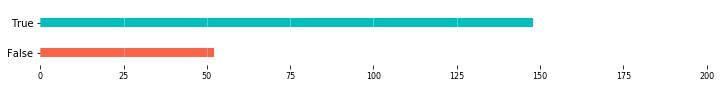

In [41]:
ax = hr.exists.value_counts().sort_values().plot(kind='barh', color=['tomato', 'c'], figsize=(12,1), width=0.3)
plt.xlim(0,201), plt.xticks(fontsize=8), ax.set_frame_on(False), plt.grid(color='white', alpha=.4, axis='x')

**Plot with semi-colon :**

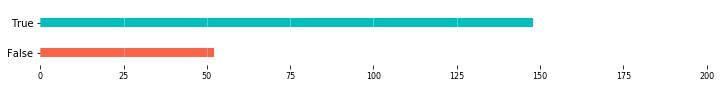

In [39]:
ax = hr.exists.value_counts().sort_values().plot(kind='barh', color=['tomato', 'c'], figsize=(12,1), width=0.3)
plt.xlim(0,201), plt.xticks(fontsize=8), ax.set_frame_on(False), plt.grid(color='white', alpha=.4, axis='x') ;

<a id='codex5'></a>
* ### Code explanation 5: 
[<sub>Go back to the code</sub>](#code5)

```
it['username'] = it['email'].str.replace('@giantbabybibs.org', '')
it.head(3)```

This is a simple one: we use the Pandas attribute (or accessor) `str`, followed by the method `.replace()` in order to replace the domaine name with an empty character (which has the same result as deleting the domaine name). The values are then assigned to the newly created column `username`.

<a id='codex6'></a>
* ### Code explanation 6: 
[<sub>Go back to the code</sub>](#code6)

```
actual_email = []
similarity = []

for i in hr.full_name:
        ratio = process.extract( i, it.username, limit=1)
        actual_email.append(ratio[0][0])
        similarity.append(ratio[0][1])

hr['actual_email'] = pd.Series(actual_email)
hr['actual_email'] = hr['actual_email'] + '@giantbabybibs.org'
hr['similarity'] = pd.Series(similarity)

hr.head(3)
```

There are 3 steps here :
1. We create two empty lists: `actual_email` and `similarity` ;
2. We use a `for` loop that iterates over each element of `hr.full_name` and applies the indented code or statement after it. Let's see what that statement does :

    * `ratio = process.extract( i, it.username, limit=1)`: this calculates the ratio of `i` (which is a full name from `r.full_name` compared to all elements in `it.username`. Normally, this would return a list of tuples containing all the elements in `it.username` coupled with their respective ratios and indexes. However, because we specified the parameter `limit=1`, we'll only get the highest rated element. If we run this bit of code alone, we'll get :
    
    <pre>process.extract( 'Tony Stark', it.username, limit=1)
         Output: [('t.stark', 82, 182)]</pre>
         
    As you can see, we get the matching element `t.stark`, its ratio `82` and its index in `it.username` which is `182`. Now this whole list is assigned to a variable called `ratio`.

    * `actual_email.append(ratio[0][0])`: in this line, we take the element ratio[0][0], which is the first element in the first tuple `t.stark`, and we append it (add it) to the list `actual_email`.
    * `similarity.append(ratio[0][1])`: likewise, we take the element ratio[0][1], which is the second element in the first tuple `82` and we append it to the list `similarity`.
    
    By the end of this loop, we'll end up with two lists: `actual_email` filled with all the best matching usernames, and `similarity` that holds all of their respective ratios.
    
    
3. The third part comes after the completion of the for loop. Here, we create a new column called `actual_email` and we populate if with all the values from the list `actual_email`, and then we add the domaine name to it to make an email out of the usernames. We do the same thing with `similarity`.

<a id='codex7'></a>
* ### Code explanation 7: 
[<sub>Go back to the code</sub>](#code7)

```
final_result = hr[['full_name', 'actual_email', 'similarity']]
final_result.head(3)
```

In Pandas, if you have a dataframe with many columns, you can choose which columns to show by using double brackets [[ ]]. You can also make a new dataframe out of this selection if you assign it to a variable. However, make sure changes to the selection do not impact the original dataframe (in our case, we don't have to worry about that because no changes were made to the newly created `final_resul` dataframe).

<a id='codex8'></a>
* ### Code explanation 8: 
[<sub>Go back to the code</sub>](#code8)

```
final_result.head(8).style.background_gradient(subset='similarity', cmap='summer_r') \
                    .set_table_styles(styles)
```

In this code, we use `style.background_gradient` to apply the colormap `summer_r` to the subset or column `similarity`. `set_table_styles` reapplies the CSS we first introduced in at the beginning. The backslash or reverse slash is used here to mark a new line (or line break) without breaking the code (very useful if you want to keep clarity with long lines of code).

<a id='codex9'></a>
* ### Code explanation 9: 
[<sub>Go back to the code</sub>](#code9)

```
final_result[final_result['full_name'].str.contains('.', regex=False)]
```

We use the `str` accessor and its method `contains` to filter all rows in which the full name contains the character DOT. We're turning off Regex here because DOT is a literal string we're looking for and not a Regular Expression (RegEx).

<a id='codex10'></a>
* ### Code explanation 10: 
[<sub>Go back to the code</sub>](#code10)

```
def scorer_tester_function(x) :
    actual_email = []
    similarity = []
    
    for i in scorer_test['full_name']:
        ratio = process.extract( i, it.username, limit=1, scorer=scorer_dict[x])
        actual_email.append( ratio[0][0] )
        similarity.append( ratio[0][1] )

        scorer_test['actual_email'] = pd.Series(actual_email)
        scorer_test['actual_email'] = scorer_test['actual_email'] + '@giantbabybibs.org'
        scorer_test['similarity'] = pd.Series(similarity)
        
    return scorer_test
```

Here, we take the code in Code expalantion 7 and slap it inside a function (so we don't have to retype the whole code every time we want to execute it). The function takes one parameter, which is the scorer, and returns a dataframe `scorer_test`. And because we specified here `scorer = scorer_dict[x]`, we only need to supply the abbrevation of a scorer as the x paramter for the function to work. 

<a id='codex11'></a>
* ### Code explanation 11: 
[<sub>Go back to the code</sub>](#code11)

```
scorer_tester_function('WR')
scorer_test[scorer_test.full_name.str.contains('.', regex=False)]
```

See Code explanation 10 and then Code explanation 9.

<a id='codex12'></a>
* ### Code explanation 12: 
[<sub>Go back to the code</sub>](#code12)

```
print("Friend's address : ", friend_address, '\n', 62*'-', '\n')

for address in phonebook:
    ratio = fuzz.ratio(friend_address, address)
    print(address,'\nRATIO: ',ratio, '\n')
```

This is a simple one. Inside the parenthese of the `print` function, we have elements we want to print (show on the screen), separated by commas. The first element, `"Friend's address : "` is a simple string. The second is the variable `friend_address`. The third is a new line or a line break. The fourth is dash printed 62 times. The fifth is another line break. You can use the `+` operator to link all of these elements inside `print()`, but then you'll have to convert them all into string for it to work:

`print( "Friend's address : " + str(friend_address) + '\n', 62*'-', '\n')`

The second part is simply a `for` loop that goes over all the addresses in the phonebook and calculates their ratios in comparison to the friend's address.

<a id='parting'></a>

---
[Go back to table of contents ^](#table)
# Parting notes :

I just hope I didn't bore you guys to death!